In [1]:
{-# LANGUAGE FlexibleContexts, MonadComprehensions, NoImplicitPrelude, RebindableSyntax, DeriveGeneric, DeriveAnyClass #-}
import Language.Stochaskell
stochaskell

Stochaskell, version 0.1.0
Copyright (C) 2015-2020 David A Roberts
This program comes with ABSOLUTELY NO WARRANTY.
This is free software, and you are welcome to redistribute it
under certain conditions; see the LICENSE for details.

Using installation directory at 
  /home/jovyan/stochaskell

In [2]:
soccer1 :: Z -> P (R,ZVec)
soccer1 n = do
  lam <- gamma 25 10
  y <- joint vector [ poisson lam
                    | _ <- 1...n ]
  return (lam,y)

soccer2 :: Z -> P (R,R,ZVec)
soccer2 n = do
  lam <- gamma 25 10
  kap <- gamma 1 10
  let a = 1/kap
      b = a/lam
  y <- joint vector [ negBinomial a b
                    | _ <- 1...n ]
  return (lam,kap,y)

In [3]:
import Language.Stochaskell.Expression
import GHC.Generics (Generic)

In [4]:
data Model = Model1 R ZVec
           | Model2 R R ZVec
           deriving (Show, Generic, ExprType, Constructor)

In [5]:
soccer :: Z -> P (Expr Model)
soccer n = do
  (lam1,     y1) <- soccer1 n
  (lam2,kap2,y2) <- soccer2 n
  k <- bernoulli 0.5
  return $ if k
    then fromConcrete (Model1 lam1 y1)
    else fromConcrete (Model2 lam2 kap2 y2)

In [6]:
soccerJump :: Model -> P (Expr Model)
soccerJump (Model1 lam y) = do
  u <- normal 0 1.5
  let kap = 0.015 * exp u
  return $ fromConcrete (Model2 lam kap y)
soccerJump (Model2 lam _ y) =
  return $ fromConcrete (Model1 lam y)

In [7]:
soccerHMC :: Z -> Model -> IO Model
soccerHMC n (Model1 lam y) = do
  let posterior =
       [ lam'
       | (lam',y') <- soccer1 n
       , y' == y ]
  samples <- hmcStanInit 10 posterior lam
  let lam' = last samples
  return (Model1 lam' y)
soccerHMC n (Model2 lam kap y) = do
  let posterior =
       [ (lam',kap')
       | (lam',kap',y') <- soccer2 n
       , y' == y ]
  let s0 = (lam,kap)
  samples <- hmcStanInit 10 posterior s0
  let (lam',kap') = last samples
  return (Model2 lam' kap' y)

In [8]:
soccerStep :: Z -> Model -> IO Model
soccerStep n m = do
  m' <- soccerHMC n m
  m'' <- soccer n `rjmcC` soccerJump
           `runCC` fromConcrete m'
  return $ fromRight (eval' m'')

In [9]:
-- https://cran.r-project.org/web/packages/engsoccerdata/README.html
totgoal = [5, 1, 3, 2, 3, 2, 2, 5, 3, 1, 0, 7, 2, 4, 4, 2, 4, 5, 6, 0, 4, 1, 4, 1, 2, 4, 0, 2, 1, 2, 5, 3, 1, 3, 2, 0, 3, 2, 2, 1, 3, 1, 1, 0, 1, 1, 4, 3, 4, 3, 0, 5, 1, 2, 2, 3, 2, 1, 2, 2, 0, 5, 1, 2, 3, 1, 2, 7, 5, 3, 3, 2, 0, 2, 5, 2, 2, 2, 1, 0, 5, 2, 1, 3, 4, 2, 3, 2, 2, 1, 2, 1, 2, 5, 2, 1, 0, 2, 2, 1, 2, 0, 2, 2, 7, 4, 3, 4, 3, 2, 5, 0, 2, 1, 1, 3, 2, 6, 6, 2, 3, 5, 2, 2, 3, 1, 3, 2, 2, 3, 4, 5, 1, 1, 5, 0, 1, 4, 4, 2, 4, 4, 1, 2, 1, 1, 1, 4, 1, 4, 3, 1, 4, 6, 0, 3, 3, 3, 1, 1, 2, 3, 5, 1, 1, 4, 3, 1, 7, 3, 1, 1, 4, 2, 1, 1, 0, 5, 4, 6, 1, 0, 2, 2, 3, 1, 1, 1, 2, 3, 4, 4, 5, 0, 1, 5, 1, 2, 3, 1, 4, 1, 3, 3, 3, 2, 0, 3, 1, 2, 1, 3, 3, 5, 4, 1, 2, 6, 1, 2, 0, 2, 3, 0, 2, 3, 1, 4, 3, 4, 1, 2, 7, 3, 3, 1, 5, 0, 0, 5, 3, 2, 2, 6, 4, 2, 5, 1, 2, 1, 1, 4, 0, 1, 2, 2, 4, 1, 2, 4, 2, 5, 4, 3, 0, 4, 2, 2, 2, 4, 2, 3, 2, 1, 1, 4, 3, 4, 1, 0, 3, 2, 1, 2, 2, 3, 4, 1, 1, 0, 4, 3, 1, 3, 2, 3, 4, 3, 5, 5, 2, 2, 2, 1, 2, 0, 2, 5, 1, 4, 2, 2, 1, 0, 3, 3, 2, 2, 4, 5, 3, 2, 4, 3, 3, 5, 2, 0, 3, 3, 4, 0, 2, 2, 3, 2, 3, 3, 1, 2, 1, 3, 0, 4, 3, 4, 3, 0, 4, 4, 3, 3, 1, 3, 3, 6, 6, 2, 3, 1, 2, 5, 5, 2, 3, 3, 3, 1, 2, 1, 1, 7, 3, 2, 1, 3, 1, 3, 1, 3, 2, 8, 3, 4, 2, 2, 4, 3, 4, 3, 2, 2, 4, 3, 3, 3, 3, 1, 3, 1, 2, 1, 2, 0, 2, 2, 0, 4, 3, 2, 2, 0, 3, 3, 2, 2, 1, 2, 2, 3, 1, 5, 2, 2, 2, 1, 6, 1, 3, 4, 3, 6, 3, 2, 4, 3, 3, 4, 4, 3, 2, 1, 2, 3, 2, 0, 4, 0, 3, 5, 4, 1, 2, 1, 4, 1, 3, 3, 1, 2, 1, 2, 4, 3, 1, 3, 4, 2, 1, 0, 2, 2, 0, 4, 1, 2, 2, 3, 4, 3, 2, 4, 1, 3, 0, 3, 1, 3, 4, 3, 1, 4, 1, 4, 1, 1, 1, 1, 3, 5, 5, 3, 2, 6, 0, 3, 3, 2, 2, 3, 3, 2, 4, 3, 2, 2, 2, 3, 2, 1, 1, 4, 3, 3, 3, 2, 1, 1, 2, 0, 0, 1, 5, 4, 2, 3, 4, 2, 0, 4, 1, 1, 2, 2, 0, 2, 4, 3, 2, 3, 2, 1, 2, 3, 2, 0, 1, 3, 4, 0, 1, 1, 0, 0, 2, 0, 3, 0, 2, 1, 1, 4, 5, 5, 2, 2, 3, 6, 2, 4, 2, 2, 3, 5, 2, 1, 4, 1, 4, 2, 4, 1, 6, 2, 3, 3, 4, 0, 2, 3, 1, 4, 3, 4, 5, 5, 1, 2, 0, 4, 2, 3, 0, 0, 2, 3, 3, 1, 4, 0, 1, 5, 1, 4, 3, 4, 3, 0, 4, 3, 1, 1, 2, 2, 2, 3, 3, 3, 0, 3, 4, 4, 2, 3, 2, 1, 4, 2, 3, 1, 2, 1, 2, 1, 3, 1, 2, 5, 1, 0, 4, 4, 2, 6, 5, 1, 4, 0, 4, 3, 2, 2, 2, 2, 1, 3, 3, 3, 2, 3, 3, 1, 3, 3, 4, 3, 2, 5, 6, 3, 2, 0, 1, 3, 4, 3, 5, 3, 1, 2, 4, 1, 4, 3, 0, 3, 1, 4, 1, 3, 6, 3, 2, 3, 2, 2, 6, 0, 1, 0, 2, 2, 1, 2, 3, 4, 4, 5, 1, 6, 3, 1, 1, 2, 2, 3, 1, 1, 7, 1, 2, 1, 0, 3, 4, 5, 5, 2, 0, 4, 4, 4, 1, 1, 1, 1, 1, 6, 2, 3, 2, 2, 2, 2, 1, 5, 1, 3, 2, 1, 4, 2, 3, 4, 2, 5, 3, 2, 2, 3, 6, 2, 4, 2, 2, 2, 3, 3, 2, 5, 2, 5, 4, 4, 1, 3, 1, 2, 4, 3, 5, 1, 1, 2, 2, 2, 4, 4, 1, 3, 2, 2, 2, 4, 5, 1, 5, 2, 4, 3, 5, 1, 4, 0, 2, 0, 1, 2, 2, 4, 1, 6, 1, 2, 1, 4, 5, 2, 3, 3, 1, 1, 3, 0, 4, 0, 1, 0, 4, 1, 3, 2, 2, 1, 5, 3, 8, 5, 0, 2, 7, 2, 0, 0, 6, 3, 1, 3, 1, 1, 2, 2, 1, 2, 8, 6, 3, 3, 2, 2, 2, 4, 3, 2, 1, 1, 1, 4, 4, 0, 3, 5, 1, 5, 4, 4, 2, 2, 1, 1, 3, 3, 1, 1, 2, 4, 4, 1, 8, 0, 2, 3, 3, 3, 2, 4, 3, 3, 0, 1, 2, 6, 3, 3, 1, 2, 4, 4, 6, 1, 2, 2, 4, 0, 4, 4, 2, 6, 1, 2, 1, 1, 5, 3, 5, 3, 3, 4, 4, 2, 4, 1, 1, 4, 6, 2, 1, 2, 5, 0, 1, 4, 4, 4, 3, 1, 3, 2, 0, 3, 4, 1, 2, 2, 2, 5, 3, 2, 3, 3, 5, 6, 2, 0, 1, 1, 5, 4, 3, 3, 2, 3, 1, 2, 1, 2, 1, 2, 9, 4, 4, 2, 1, 4, 2, 3, 1, 2, 0, 3, 1, 0, 2, 4, 5, 2, 3, 2, 6, 2, 5, 3, 2, 4, 4, 1, 0, 2, 6, 1, 4, 2, 4, 0, 1, 0, 0, 2, 1, 0, 11, 1, 1, 0, 2, 4, 3, 3, 0, 2, 3, 1, 1, 2, 4, 2, 2, 2, 3, 2, 3, 1, 3, 3, 1, 2, 2, 3, 4, 1, 1, 1, 2, 2, 3, 4, 5, 2, 2, 3, 1, 3, 2, 4, 8, 5, 3, 2, 8, 4, 4, 6, 2, 3, 2, 2, 5, 2, 10, 2, 4, 4, 1, 4, 2, 3, 2, 4, 3, 2, 3, 1, 2, 3, 3, 4, 1, 2, 4, 2, 2, 0, 3, 2, 8, 1, 2, 2, 3, 2, 1, 2, 2, 1, 1, 2, 0, 3, 2, 1]

In [10]:
let goalData = list totgoal
    n = integer (length totgoal)

In [11]:
compileCC (soccer n `rjmcC` soccerJump)

/*
let v_0_0 = getExternal x_cc_0_0 :: Union[(R, ZVec), (R, R, ZVec)]
 in do x_cc_0_0 <- switch i_0_0 of
         C0 i_1_0 i_1_1 ->
           let v_1_0 = getExternal x_cc_1_0 :: R
               v_1_1 = gamma_lpdf i_1_0 25.0 10.0 :: R
               v_1_2 = exp x_cc_1_0 :: R
               v_1_3 = 1.5e-2 * v_1_2 :: R
               v_1_4 = gamma_lpdf v_1_3 1.0 10.0 :: R
               v_1_5 = 1.0 / v_1_3 :: R
               v_1_6 = v_1_5 / i_1_0 :: R
               v_1_7 = vectorSize i_1_1 :: Z
               v_1_8 = 
                 [ i_2_1
                 | i_2_1 <- 1...v_1_7 ] :: ZVec
               v_1_9 = foldl 0.0 v_1_8 $ \i_2_12 i_2_11 ->
                 let v_2_0 = neg_binomial_lpdf i_1_1!i_2_11 v_1_5 v_1_6 :: R
                     v_2_1 = i_2_12 + v_2_0 :: R
                  in v_2_1 :: R
               v_1_10 = +s -0.6931471805599453 v_1_1 v_1_4 v_1_9 :: R
               v_1_11 = foldl 0.0 v_1_8 $ \i_2_12 i_2_11 ->
                 let v_2_0 = poisson_lpdf i_1_1!i_2_11 

In [12]:
import System.IO
progress :: (a -> IO b) -> a -> IO b
progress f x = do
  putStr "."
  hFlush stdout
  silence' (f x)

In [13]:
samples <- iterateLimit 500 (progress $ soccerStep n) (Model1 1 goalData)

....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [14]:
putStrLn "Posterior probability in favour of model 1:"
sum [case m of Model1{} -> 1; _ -> 0 | m <- samples] / genericLength samples

Posterior probability in favour of model 1:

0.7065868263473054

In [15]:
:opt svg
import Language.Stochaskell.Plot

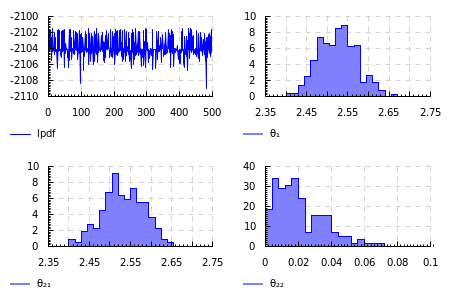

In [16]:
let plot' = layoutToGrid . execEC . plot
    hist s vals rng = return . histToPlot $ defaultNormedPlotHist
      { _plot_hist_title = s, _plot_hist_values = vals, _plot_hist_range = Just rng }

toRenderable $ 
  (plot' (line "lpdf" [[(i, real $ soccer n `lpdfAuxC` fromConcrete m) | (i,m) <- [1..] `zip` tail samples]]) `beside`
   plot' (hist "θ₁" [real lam | Model1 lam _ <- samples] (2.4,2.7)))
  `above`
  (plot' (hist "θ₂₁" [real lam | Model2 lam kap _ <- samples] (2.4,2.7)) `beside`
   plot' (hist "θ₂₂" [real kap | Model2 lam kap _ <- samples] (0,0.08)))